## Victor Gómez
### victor.gomez@cimat.mx


# Maestría en Cómputo Estadístico
# CIMAT Monterrey

# <center>Tópicos selectos de Cómputo<center>
# <center>Tarea 2: Clases con ruido <center>

Instrucciones: 
- Usa python 3.x y xgboost 1.x
- ejecuta todas las celdas para replicar los resultados

In [3]:
#Librerías necesarias
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  RepeatedKFold, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.svm import SVC
from imblearn.pipeline  import Pipeline
from sklearn.metrics import accuracy_score

# Clase para manejo de ruido en clases por distintos metodos.

## Métodos de manejo de ruido:

- 1 Métodos de filtro de ruido: ENN
- 2 Métodos de filtro de ruido: EF
- 3 Métodos de filtro de ruido: CMTNN
- 4 Métodos de pulido de ruido: IterativeEdition
- 5 Métodos de pulido de ruido: HybridRepairingFilter

In [4]:
from _noise import NoiseHandling #Clase para manejo de ruido en clases por distintos metodos

## Conjuntos de datos con ruido (5, 10, 15 y 20%):
datasets de: https://sci2s.ugr.es/keel/classNoise.php

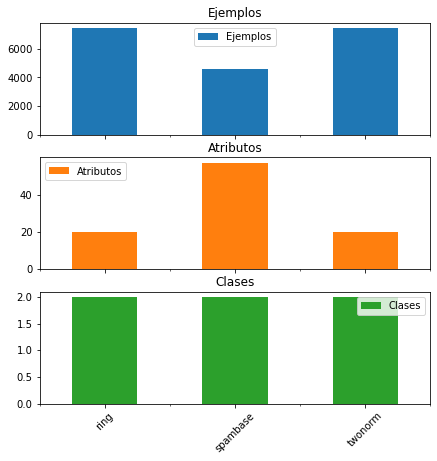

In [5]:
names=['ring','spambase','twonorm']
Ejemplos=[7400,4597,7400]
attributes=[20,57,20]
clases=[2,2,2]


df_noise_dict={
            'Ejemplos': Ejemplos,
            'Atributos': attributes,
             'Clases': clases}

df_noise=pd.DataFrame(df_noise_dict)
df_noise.index=names

axes = df_noise.plot.bar(rot=45, subplots=True,figsize=(7,7))
axes[1].legend(loc=2)  

Se seleccionaron 12 conjuntos de datos presentan diferentes características, la cantidad de ejemplos que  esta entre 8000 y 4000, todos son de 2 clases, con 5, 10, 15 y 20% de ruido en las clases. Se utilizaron conjuntos de prueba del 20% del original, estos no contienen ruido y se utilizaron para obtener el accuracy.

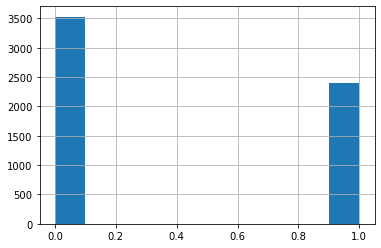

In [9]:
noise=['5','10','15','20']
dataset=['tra','tst']
names=['ring','spambase','twonorm']
df_train = pd.read_table(names[0]+'-'+noise[3]+'cn10-nc-5-1'+dataset[0]+'.dat', sep=',', header=None, na_values=[' ','  ','?',None])
df_test = pd.read_table(names[0]+'-'+noise[3]+'cn10-nc-5-1'+dataset[1]+'.dat', sep=',', header=None, na_values=[' ','  ','?',None])
df_train.iloc[:,-1].hist()

algunos de los conjuntos de datos muestran un desbalance en las clases.

## Modelos de ML para clasificación. Ajuste mediante RandomizedSearchCV con validación cruzada (5x2) y metrica accuracy:

- 1 KNeighbors: k: [2-40]
- 2 XGBoost: learning rate: [0.1,0.3,0.6], n_estimators: [50,150,300,500], subsample: [0.5,0.75,0.9], colsample_bytree: [0.5,0.75,0.9], regularización: gamma: [0,10,100], lambda: [1,10,100]
- 3 SVM: parameters = C: [0.1, 10], kernel: ['linear'],C: [ 1,5, 10,20], gamma: [0.001, 0.01, 0.1], kernel: ['rbf']

In [5]:
def df_clean(df): #libera memoria
    df=pd.DataFrame()
    del df
    
#Models:
#K Neighbors
def KNN_model():
    params={'n_neighbors':np.random.randint(2,40, size=10)}
    return KNeighborsClassifier(), params

#XGBoost
def XGBoost_model(num_classes=2):
    
    gbm_param_grid={'learning_rate':[0.1,0.3,0.6],
               'n_estimators':[50,150,300,500],
               'subsample':[0.5,0.75,0.9],
                'colsample_bytree':[0.5,0.9,1],
               'gamma':[0,10,100],
               'lambda':[1,10,100]}
    
    if num_classes ==2:
        gbm=xgb.XGBClassifier()
                
    else:
        gbm=xgb.XGBClassifier(objective='multi:softmax')
    
    return gbm, gbm_param_grid 



#SVM
def SVM_model():
    parameters = [{'C': [0.1, 10], 'kernel': ['linear']},{'C': [ 1,5, 10,20], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['rbf']}]
        
    return SVC(), parameters

def data_prep(df_train,df_test,method):
    X_train, y_train = df_train.iloc[:,:-1].values, df_train.iloc[:,-1].values
    X_test, y_test = df_test.iloc[:,:-1].values, df_test.iloc[:,-1].values
    scaler = StandardScaler() #Standardize
    scaler.fit(X_train)
    X_train=scaler.transform(X_train)
    X_test=scaler.transform(X_test)
    if method!='NoPrep':
        nh=NoiseHandling(method = method)
        X_train, y_train=nh.fit_resample(X_train, y_train)
    
    return X_train, y_train, X_test, y_test

rkf = RepeatedKFold(n_splits=2, n_repeats=5)
#prepara los datos, entrena, y obtiene scores para cada modelo
def Mod_train(X_train, y_train,X_test, y_test,model_name,cv=rkf): 
    
    if model_name=='KNN':
        classifier,params=KNN_model()
        
    elif model_name=='XGB':
        classifier,params=XGBoost_model()

    elif model_name=='SVM':
        classifier,params=SVM_model()
        
    model = Pipeline([('RandomizedSearchCV', RandomizedSearchCV(classifier,param_distributions=params,scoring='accuracy',cv=cv,n_jobs=-1))])

    model.fit(X_train, y_train)
    y_test_pred=model.predict(X_test)
    score=accuracy_score(y_test, y_test_pred)
    
    return score


# 1.- Importación de los conjuntos de datos, manejo de ruido, Ajuste de modelos con Validacion cruzada (5x2).

In [10]:
startTime = datetime.now()
#importa los conjuntos de datos
names=['ring','spambase','twonorm']
noise_levels=['5','10','15','20']
dataset=['tra','tst']
noise_method=['NoPrep','ENN','EF','CMTNN','IterativeEdition','HybridRepairingFilter']
model_name=['KNN','XGB','SVM']

results_NoPrep=[]
results_ENN=[]
results_EF=[]
results_CMTNN=[]
results_IterativeEdition=[]
results_HybridRepairingFilter=[]

for name in names: #abre los conjuntos de datos
    for noise in noise_levels: #por nivel de ruido
        df_train = pd.read_table(name+'-'+noise+'cn10-nc-5-1'+dataset[0]+'.dat', sep=',', header=None, na_values=[' ','  ','?',None])
        df_test = pd.read_table(name+'-'+noise+'cn10-nc-5-1'+dataset[1]+'.dat', sep=',', header=None, na_values=[' ','  ','?',None])
        for method in noise_method: # imputa datos faltantes con cada metodo
            X_train, y_train, X_test, y_test=data_prep(df_train,df_test,method)
            for model in model_name: #ajusta modelos de Machine Learning
                score=Mod_train(X_train, y_train,X_test, y_test,model)
                #imprime y guarda resultados
                print('DataFrame: '+name+' noise_level :'+noise+' method: '+method+' model :'+model+' score: ',round(score,3))
                
                if method=='NoPrep':
                    results_NoPrep.append(score)
                    
                elif method=='ENN':
                    results_ENN.append(score)
                elif method=='EF':
                    results_EF.append(score)
                elif method=='CMTNN':
                    results_CMTNN.append(score)
                    
                elif method=='IterativeEdition':
                    results_IterativeEdition.append(score)
                elif method=='HybridRepairingFilter':
                    results_HybridRepairingFilter.append(score)

        df_clean(df_train)
        df_clean(df_test) #libera memoria
print('Tiempo total: ',datetime.now() - startTime) #tiempo total

DataFrame: ring noise_level :5 method: NoPrep model :KNN score:  0.759
DataFrame: ring noise_level :5 method: NoPrep model :XGB score:  0.964
DataFrame: ring noise_level :5 method: NoPrep model :SVM score:  0.978
DataFrame: ring noise_level :5 method: ENN model :KNN score:  0.547
DataFrame: ring noise_level :5 method: ENN model :XGB score:  0.922
DataFrame: ring noise_level :5 method: ENN model :SVM score:  0.957
DataFrame: ring noise_level :5 method: EF model :KNN score:  0.624
DataFrame: ring noise_level :5 method: EF model :XGB score:  0.943
DataFrame: ring noise_level :5 method: EF model :SVM score:  0.968


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


DataFrame: ring noise_level :5 method: CMTNN model :KNN score:  0.782
DataFrame: ring noise_level :5 method: CMTNN model :XGB score:  0.97
DataFrame: ring noise_level :5 method: CMTNN model :SVM score:  0.978
DataFrame: ring noise_level :5 method: IterativeEdition model :KNN score:  0.536
DataFrame: ring noise_level :5 method: IterativeEdition model :XGB score:  0.67
DataFrame: ring noise_level :5 method: IterativeEdition model :SVM score:  0.696
DataFrame: ring noise_level :5 method: HybridRepairingFilter model :KNN score:  0.776
DataFrame: ring noise_level :5 method: HybridRepairingFilter model :XGB score:  0.956
DataFrame: ring noise_level :5 method: HybridRepairingFilter model :SVM score:  0.975
DataFrame: ring noise_level :10 method: NoPrep model :KNN score:  0.691
DataFrame: ring noise_level :10 method: NoPrep model :XGB score:  0.96
DataFrame: ring noise_level :10 method: NoPrep model :SVM score:  0.979
DataFrame: ring noise_level :10 method: ENN model :KNN score:  0.677
DataFra

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


DataFrame: ring noise_level :10 method: CMTNN model :KNN score:  0.704
DataFrame: ring noise_level :10 method: CMTNN model :XGB score:  0.955
DataFrame: ring noise_level :10 method: CMTNN model :SVM score:  0.977
DataFrame: ring noise_level :10 method: IterativeEdition model :KNN score:  0.516
DataFrame: ring noise_level :10 method: IterativeEdition model :XGB score:  0.711
DataFrame: ring noise_level :10 method: IterativeEdition model :SVM score:  0.72
DataFrame: ring noise_level :10 method: HybridRepairingFilter model :KNN score:  0.786
DataFrame: ring noise_level :10 method: HybridRepairingFilter model :XGB score:  0.916
DataFrame: ring noise_level :10 method: HybridRepairingFilter model :SVM score:  0.976
DataFrame: ring noise_level :15 method: NoPrep model :KNN score:  0.718
DataFrame: ring noise_level :15 method: NoPrep model :XGB score:  0.951
DataFrame: ring noise_level :15 method: NoPrep model :SVM score:  0.975
DataFrame: ring noise_level :15 method: ENN model :KNN score:  0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


DataFrame: ring noise_level :15 method: CMTNN model :KNN score:  0.755
DataFrame: ring noise_level :15 method: CMTNN model :XGB score:  0.965
DataFrame: ring noise_level :15 method: CMTNN model :SVM score:  0.976
DataFrame: ring noise_level :15 method: IterativeEdition model :KNN score:  0.509
DataFrame: ring noise_level :15 method: IterativeEdition model :XGB score:  0.726
DataFrame: ring noise_level :15 method: IterativeEdition model :SVM score:  0.727
DataFrame: ring noise_level :15 method: HybridRepairingFilter model :KNN score:  0.788
DataFrame: ring noise_level :15 method: HybridRepairingFilter model :XGB score:  0.93
DataFrame: ring noise_level :15 method: HybridRepairingFilter model :SVM score:  0.973
DataFrame: ring noise_level :20 method: NoPrep model :KNN score:  0.729
DataFrame: ring noise_level :20 method: NoPrep model :XGB score:  0.94
DataFrame: ring noise_level :20 method: NoPrep model :SVM score:  0.971
DataFrame: ring noise_level :20 method: ENN model :KNN score:  0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


DataFrame: ring noise_level :20 method: CMTNN model :KNN score:  0.767
DataFrame: ring noise_level :20 method: CMTNN model :XGB score:  0.934
DataFrame: ring noise_level :20 method: CMTNN model :SVM score:  0.972
DataFrame: ring noise_level :20 method: IterativeEdition model :KNN score:  0.51
DataFrame: ring noise_level :20 method: IterativeEdition model :XGB score:  0.509
DataFrame: ring noise_level :20 method: IterativeEdition model :SVM score:  0.515
DataFrame: ring noise_level :20 method: HybridRepairingFilter model :KNN score:  0.688
DataFrame: ring noise_level :20 method: HybridRepairingFilter model :XGB score:  0.878
DataFrame: ring noise_level :20 method: HybridRepairingFilter model :SVM score:  0.964
DataFrame: spambase noise_level :5 method: NoPrep model :KNN score:  0.911
DataFrame: spambase noise_level :5 method: NoPrep model :XGB score:  0.95
DataFrame: spambase noise_level :5 method: NoPrep model :SVM score:  0.933
DataFrame: spambase noise_level :5 method: ENN model :KNN

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


DataFrame: spambase noise_level :5 method: CMTNN model :KNN score:  0.911
DataFrame: spambase noise_level :5 method: CMTNN model :XGB score:  0.947
DataFrame: spambase noise_level :5 method: CMTNN model :SVM score:  0.932
DataFrame: spambase noise_level :5 method: IterativeEdition model :KNN score:  0.891
DataFrame: spambase noise_level :5 method: IterativeEdition model :XGB score:  0.927
DataFrame: spambase noise_level :5 method: IterativeEdition model :SVM score:  0.921
DataFrame: spambase noise_level :5 method: HybridRepairingFilter model :KNN score:  0.91
DataFrame: spambase noise_level :5 method: HybridRepairingFilter model :XGB score:  0.946
DataFrame: spambase noise_level :5 method: HybridRepairingFilter model :SVM score:  0.93
DataFrame: spambase noise_level :10 method: NoPrep model :KNN score:  0.912
DataFrame: spambase noise_level :10 method: NoPrep model :XGB score:  0.951
DataFrame: spambase noise_level :10 method: NoPrep model :SVM score:  0.933
DataFrame: spambase noise_l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


DataFrame: spambase noise_level :10 method: CMTNN model :KNN score:  0.905
DataFrame: spambase noise_level :10 method: CMTNN model :XGB score:  0.952
DataFrame: spambase noise_level :10 method: CMTNN model :SVM score:  0.93
DataFrame: spambase noise_level :10 method: IterativeEdition model :KNN score:  0.892
DataFrame: spambase noise_level :10 method: IterativeEdition model :XGB score:  0.937
DataFrame: spambase noise_level :10 method: IterativeEdition model :SVM score:  0.924
DataFrame: spambase noise_level :10 method: HybridRepairingFilter model :KNN score:  0.912
DataFrame: spambase noise_level :10 method: HybridRepairingFilter model :XGB score:  0.949
DataFrame: spambase noise_level :10 method: HybridRepairingFilter model :SVM score:  0.934
DataFrame: spambase noise_level :15 method: NoPrep model :KNN score:  0.917
DataFrame: spambase noise_level :15 method: NoPrep model :XGB score:  0.93
DataFrame: spambase noise_level :15 method: NoPrep model :SVM score:  0.926
DataFrame: spambas

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


DataFrame: spambase noise_level :15 method: CMTNN model :KNN score:  0.914
DataFrame: spambase noise_level :15 method: CMTNN model :XGB score:  0.928
DataFrame: spambase noise_level :15 method: CMTNN model :SVM score:  0.923
DataFrame: spambase noise_level :15 method: IterativeEdition model :KNN score:  0.903
DataFrame: spambase noise_level :15 method: IterativeEdition model :XGB score:  0.933
DataFrame: spambase noise_level :15 method: IterativeEdition model :SVM score:  0.918
DataFrame: spambase noise_level :15 method: HybridRepairingFilter model :KNN score:  0.91
DataFrame: spambase noise_level :15 method: HybridRepairingFilter model :XGB score:  0.934
DataFrame: spambase noise_level :15 method: HybridRepairingFilter model :SVM score:  0.923
DataFrame: spambase noise_level :20 method: NoPrep model :KNN score:  0.902
DataFrame: spambase noise_level :20 method: NoPrep model :XGB score:  0.94
DataFrame: spambase noise_level :20 method: NoPrep model :SVM score:  0.925
DataFrame: spambas

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


DataFrame: spambase noise_level :20 method: CMTNN model :KNN score:  0.909
DataFrame: spambase noise_level :20 method: CMTNN model :XGB score:  0.935
DataFrame: spambase noise_level :20 method: CMTNN model :SVM score:  0.924
DataFrame: spambase noise_level :20 method: IterativeEdition model :KNN score:  0.888
DataFrame: spambase noise_level :20 method: IterativeEdition model :XGB score:  0.925
DataFrame: spambase noise_level :20 method: IterativeEdition model :SVM score:  0.918
DataFrame: spambase noise_level :20 method: HybridRepairingFilter model :KNN score:  0.903
DataFrame: spambase noise_level :20 method: HybridRepairingFilter model :XGB score:  0.932
DataFrame: spambase noise_level :20 method: HybridRepairingFilter model :SVM score:  0.926
DataFrame: twonorm noise_level :5 method: NoPrep model :KNN score:  0.977
DataFrame: twonorm noise_level :5 method: NoPrep model :XGB score:  0.974
DataFrame: twonorm noise_level :5 method: NoPrep model :SVM score:  0.978
DataFrame: twonorm noi

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


DataFrame: twonorm noise_level :5 method: CMTNN model :KNN score:  0.977
DataFrame: twonorm noise_level :5 method: CMTNN model :XGB score:  0.97
DataFrame: twonorm noise_level :5 method: CMTNN model :SVM score:  0.979
DataFrame: twonorm noise_level :5 method: IterativeEdition model :KNN score:  0.977
DataFrame: twonorm noise_level :5 method: IterativeEdition model :XGB score:  0.978
DataFrame: twonorm noise_level :5 method: IterativeEdition model :SVM score:  0.976
DataFrame: twonorm noise_level :5 method: HybridRepairingFilter model :KNN score:  0.978
DataFrame: twonorm noise_level :5 method: HybridRepairingFilter model :XGB score:  0.978
DataFrame: twonorm noise_level :5 method: HybridRepairingFilter model :SVM score:  0.981
DataFrame: twonorm noise_level :10 method: NoPrep model :KNN score:  0.98
DataFrame: twonorm noise_level :10 method: NoPrep model :XGB score:  0.96
DataFrame: twonorm noise_level :10 method: NoPrep model :SVM score:  0.978
DataFrame: twonorm noise_level :10 metho

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


DataFrame: twonorm noise_level :10 method: CMTNN model :KNN score:  0.979
DataFrame: twonorm noise_level :10 method: CMTNN model :XGB score:  0.976
DataFrame: twonorm noise_level :10 method: CMTNN model :SVM score:  0.98
DataFrame: twonorm noise_level :10 method: IterativeEdition model :KNN score:  0.975
DataFrame: twonorm noise_level :10 method: IterativeEdition model :XGB score:  0.975
DataFrame: twonorm noise_level :10 method: IterativeEdition model :SVM score:  0.976
DataFrame: twonorm noise_level :10 method: HybridRepairingFilter model :KNN score:  0.978
DataFrame: twonorm noise_level :10 method: HybridRepairingFilter model :XGB score:  0.967
DataFrame: twonorm noise_level :10 method: HybridRepairingFilter model :SVM score:  0.977
DataFrame: twonorm noise_level :15 method: NoPrep model :KNN score:  0.98
DataFrame: twonorm noise_level :15 method: NoPrep model :XGB score:  0.958
DataFrame: twonorm noise_level :15 method: NoPrep model :SVM score:  0.978
DataFrame: twonorm noise_level

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


DataFrame: twonorm noise_level :15 method: CMTNN model :KNN score:  0.979
DataFrame: twonorm noise_level :15 method: CMTNN model :XGB score:  0.962
DataFrame: twonorm noise_level :15 method: CMTNN model :SVM score:  0.979
DataFrame: twonorm noise_level :15 method: IterativeEdition model :KNN score:  0.98
DataFrame: twonorm noise_level :15 method: IterativeEdition model :XGB score:  0.975
DataFrame: twonorm noise_level :15 method: IterativeEdition model :SVM score:  0.98
DataFrame: twonorm noise_level :15 method: HybridRepairingFilter model :KNN score:  0.98
DataFrame: twonorm noise_level :15 method: HybridRepairingFilter model :XGB score:  0.956
DataFrame: twonorm noise_level :15 method: HybridRepairingFilter model :SVM score:  0.978
DataFrame: twonorm noise_level :20 method: NoPrep model :KNN score:  0.977
DataFrame: twonorm noise_level :20 method: NoPrep model :XGB score:  0.926
DataFrame: twonorm noise_level :20 method: NoPrep model :SVM score:  0.98
DataFrame: twonorm noise_level :

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


DataFrame: twonorm noise_level :20 method: CMTNN model :KNN score:  0.972
DataFrame: twonorm noise_level :20 method: CMTNN model :XGB score:  0.944
DataFrame: twonorm noise_level :20 method: CMTNN model :SVM score:  0.979
DataFrame: twonorm noise_level :20 method: IterativeEdition model :KNN score:  0.971
DataFrame: twonorm noise_level :20 method: IterativeEdition model :XGB score:  0.971
DataFrame: twonorm noise_level :20 method: IterativeEdition model :SVM score:  0.979
DataFrame: twonorm noise_level :20 method: HybridRepairingFilter model :KNN score:  0.976
DataFrame: twonorm noise_level :20 method: HybridRepairingFilter model :XGB score:  0.955
DataFrame: twonorm noise_level :20 method: HybridRepairingFilter model :SVM score:  0.978
Tiempo total:  1:53:57.825588


In [11]:
#guarda los resultados

results_dict={'NoPrep':results_NoPrep,
                'ENN':results_ENN,
                'EF':results_EF,
              'CMTNN':results_CMTNN,
                'IterativeEdition':results_IterativeEdition,
                'HybridRepairingFilter':results_HybridRepairingFilter
             }
df_results=pd.DataFrame(results_dict)
df_results.to_csv('results.csv')




# 2.- Análisis estadístico de los resultados.

In [10]:
df_results = pd.read_csv('results.csv',  index_col=0)

## Descriptivo:

In [11]:
df_results.describe()

,NoPrep,ENN,EF,CMTNN,IterativeEdition,HybridRepairingFilter
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.927497,0.916157,0.932925,0.931128,0.834344,0.927670
std,0.077094,0.103360,0.070513,0.069312,0.171524,0.067666
min,0.690541,0.546622,0.623649,0.704054,0.508784,0.687838
25%,0.925507,0.922694,0.929891,0.923641,0.718074,0.915151
50%,0.951219,0.947826,0.947562,0.953790,0.919565,0.947283
75%,0.977027,0.970270,0.975000,0.976014,0.975000,0.975845
max,0.980405,0.981081,0.981081,0.980405,0.980405,0.981081


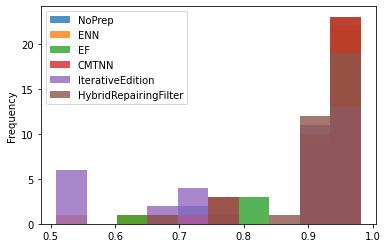

In [12]:
df_results.plot.hist(alpha=0.8) #hist

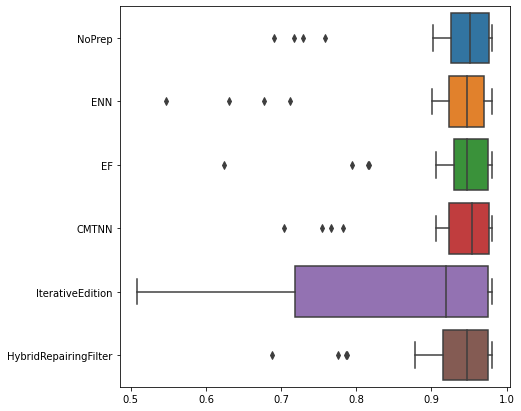

In [13]:
f, ax = plt.subplots(figsize=(7,7))
sns.boxplot(data=df_results,orient="h") #boxplot horizontal

Se puede observar que la mayoria de los métodos tienen una variación en un rango de 0.9 a 0.99, con media y mediana muy similar, pero aparentemente el método IterativeEdition se sale de este rango, es mucho mayor y hacia la izquierda, lo cual da una idea de un pobre desempeño.

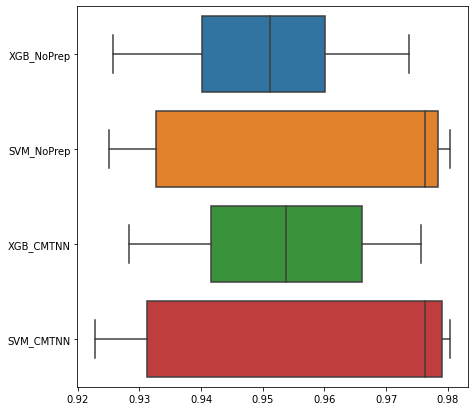

In [36]:
Robust_learners = pd.read_csv('Robust_filters.csv',  index_col=0)
f, ax = plt.subplots(figsize=(7,7))
sns.boxplot(data=Robust_learners,orient="h") #boxplot horizontal

Otro método de manejo de ruido son los Robust Learners, por ejemplo basados en arboles, por ese motivo se utilizó el modelo XGBoost como uno de los clasificadores, pero se puede observar que el desempeño de este antes y despues de ruido no parece ser muy significativo, y se tiene un comportamiendo muy similar a las maquinas de soporte vectorial, que aunque su rango es mayor, su mediana esta mas cargada a la derecha, lo cual parece indicar que ambos son muy buenos para el manejo de ruido, principalmente en este experimento las SVM.

## Friedman-test  al 5%: 

In [38]:
print('Friedman-test al 5%:')
methods=list(df_results.columns)
_,pvalue=stats.friedmanchisquare(*df_results.values.T)
print(pvalue,pvalue<0.05)

Friedman-test al 5%:
1.4208705158713269e-08 True


Se rechaza la prueba de Friedman, lo cual indica que si hay diferencias significativas entre alguna de nuestras mediciones

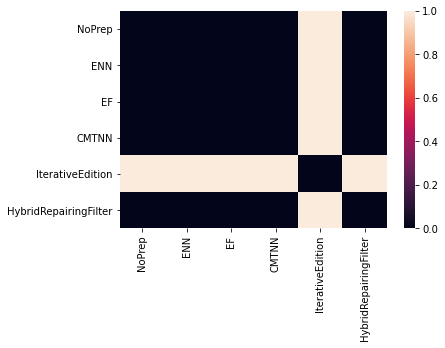

In [37]:
import scikit_posthocs as sp
df=sp.posthoc_nemenyi_friedman(df_results)
sns.heatmap(df<0.05, vmin=0, vmax=1)

Despues de aplicar el test de nemenyi friedman, se observa que la mayoria de los test pareados son similares excepto el método IterativeEdition como se habia visto anteriormente

## Conclusiones:

- El método IterativeEdition se sabe es sensible a las clases desbalanceadas, lo cual ocurre en este experimento para algunos conjuntos de datos, de hecho durante las pruabas hubo errores por lo cual se incluyó un criterio de paro si se rebasa una tolerancia para la clase minoritaria, lo cual explica que en las pruebas haya resultado significativamente diferente a todos los demás.   